In [1]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette("bright")
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Unique Detectors

In [2]:
import os
import pandas as pd
from collections import OrderedDict

def compute_unique_detectors(**kwargs):
    network_names = kwargs.get("network_names", 
                               ["resnet18"])
    datasets = kwargs.get("datasets", 
                          ["imagenet", "places365"])
    results_dir = kwargs.get("results_dir", "result")
    categories = kwargs.get("categories", 
                            ["object",
                             "scene", 
                             "part",
                             "texture", 
                             "color"])
    iou_thres = kwargs.get("iou_thres",
                           0.04) # to determine if a unit is an interpretable detector
    layer = kwargs.get("layer", "layer4")
    
    ud_data = []
    for network_name in network_names:
        for dataset in datasets:
            result_file = os.path.join(results_dir, 
                                       f"pytorch_{network_name}_{dataset}/tally_{layer}.csv")
            df_result = pd.read_csv(result_file)

            ud = OrderedDict()
            ud["network_name"] = network_name
            ud["dataset"] = dataset
            ud["num_units"] = len(df_result)

            num_ud = 0
            for category in categories:
                df_cat = df_result[df_result["category"] == category].reset_index(drop=True)
                df_unique_detectors = df_cat[df_cat[f"{category}-iou"] > iou_thres].reset_index(drop=True)
                ud[f"num_ud_{category}"] = len(df_unique_detectors)
                ud[f"num_ud_{category}_pc"] = len(df_unique_detectors) / ud["num_units"] * 100
                num_ud += len(df_unique_detectors)
            ud["num_ud"] = num_ud
            ud["num_ud_pc"] = ud["num_ud"] / ud["num_units"] * 100
            ud_data.append(ud)
    df_ud = pd.DataFrame(ud_data)
    return df_ud

In [3]:
df_ud = compute_unique_detectors()
df_ud

network_name    dataset  num_units  num_ud_object  num_ud_object_pc  \
0     resnet18   imagenet        512            160           31.2500   
1     resnet18  places365        512            120           23.4375   

   num_ud_scene  num_ud_scene_pc  num_ud_part  num_ud_part_pc  num_ud_texture  \
0            50         9.765625           26        5.078125              65   
1           256        50.000000           21        4.101562              37   

   num_ud_texture_pc  num_ud_color  num_ud_color_pc  num_ud  num_ud_pc  
0          12.695312             1         0.195312     302  58.984375  
1           7.226562             1         0.195312     435  84.960938

In [4]:
def plot_unique_detectors(df_ud, **kwargs):
    categories = kwargs.get("categories", 
                            ["object",
                             "scene", 
                             "part",
                             "texture", 
                             "color"])
    num_ud_cols = [f"num_ud_{c}" for c in categories]
    num_ud_pc_cols = [f"num_ud_{c}_pc" for c in categories]
    num_ud_col_rename = {}
    num_ud_pc_col_rename = {}
    for c in categories:
        num_ud_col_rename[f"num_ud_{c}"] = c.capitalize()
        num_ud_pc_col_rename[f"num_ud_{c}_pc"] = c.capitalize()
        
    df_ud["network_dataset"] = df_ud.apply(lambda x: x["network_name"] + "_" + x["dataset"], axis=1)
    df_ud_num = df_ud.set_index("network_dataset")[num_ud_cols]
    df_ud_num = df_ud_num.rename(columns=num_ud_col_rename)
    df_ud_num_pc = df_ud.set_index("network_dataset")[num_ud_pc_cols]
    df_ud_num_pc = df_ud_num_pc.rename(columns=num_ud_pc_col_rename)
    
    f, ax = plt.subplots(2, 1, figsize=(8, 10))
    df_ud_num.plot(kind='bar', stacked=True, ax=ax[0])
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[0].set_ylabel("Number of Unique Detectors")
    ax[0].set_xlabel("")
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)
    df_ud_num_pc.plot(kind='bar', stacked=True, ax=ax[1])
    ax[1].get_legend().remove()
    ax[1].set_ylabel("Proportion of Unique Detectors (%)")
    ax[1].set_xlabel("")
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)
    
    return f, ax

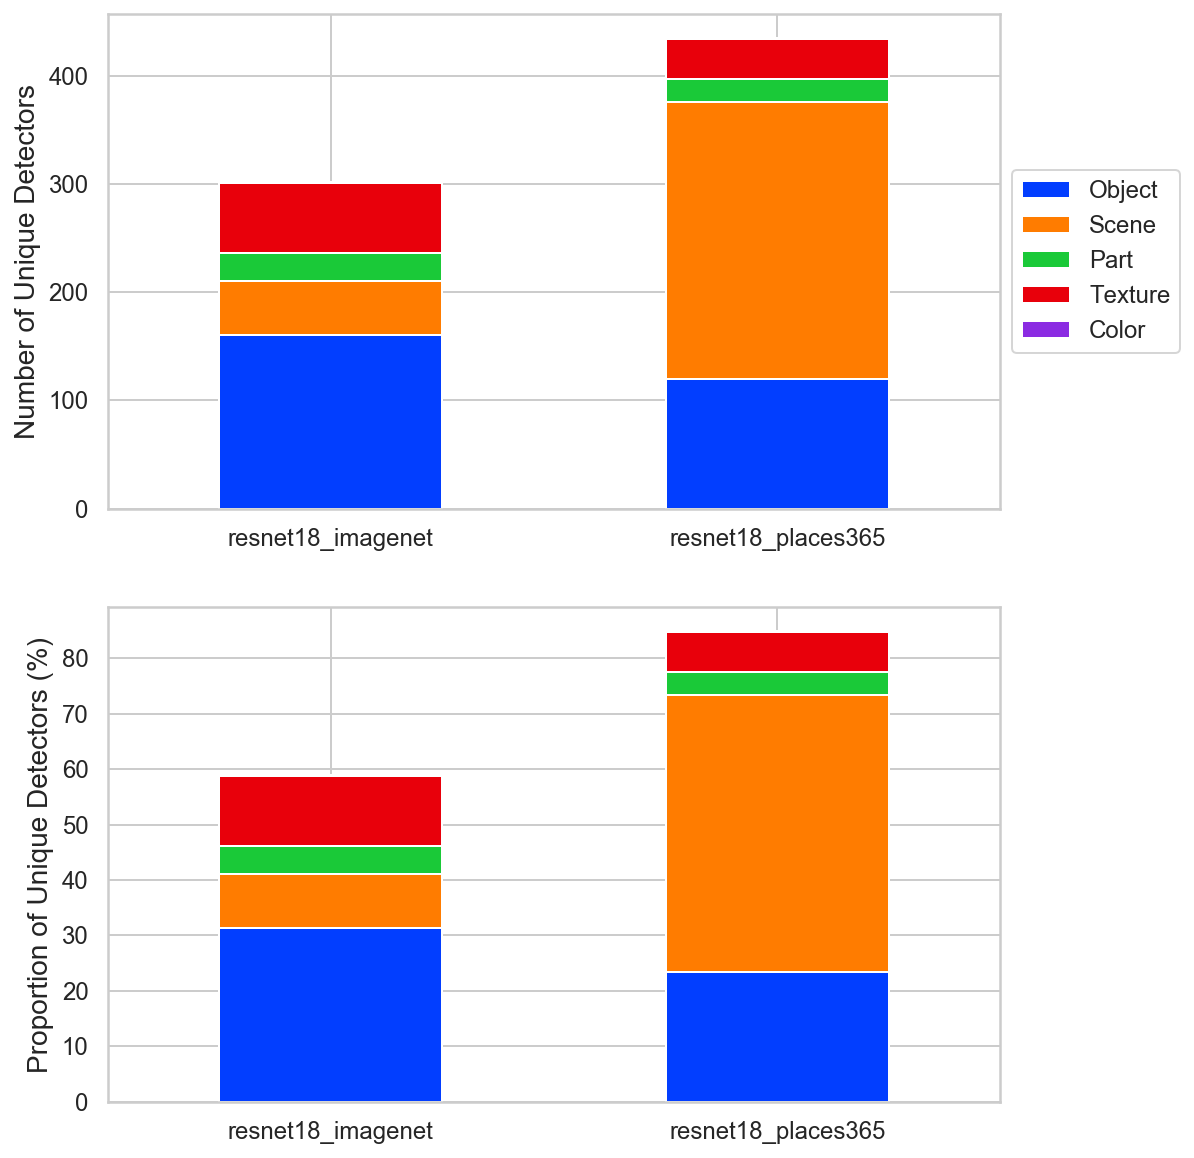

In [5]:
f, ax = plot_unique_detectors(df_ud)
f.savefig("images/chapter_06_num_unique_detectors.png", dpi=300, bbox_inches="tight")
f.savefig("images/chapter_06_num_unique_detectors.pdf", format="pdf", dpi=300, bbox_inches="tight")

# Unique Detectors - Training Task

In [6]:
def compute_unique_detectors_category_labels(**kwargs):
    network_names = kwargs.get("network_names", 
                               ["resnet18"])
    datasets = kwargs.get("datasets", 
                          ["imagenet", "places365"])
    results_dir = kwargs.get("results_dir", "result")
    categories = kwargs.get("categories", 
                            ["object",
                             "scene", 
                             "texture"])
    iou_thres = kwargs.get("iou_thres",
                           0.04) # to determine if a unit is an interpretable detector
    layer = kwargs.get("layer", "layer4")
    
    cat_label_uds_df_list = []
    for network_name in network_names:
        for dataset in datasets:
            result_file = os.path.join(results_dir, 
                                       f"pytorch_{network_name}_{dataset}/tally_{layer}.csv")
            df_result = pd.read_csv(result_file)
            
            for category in categories:
                df_cat = df_result[df_result["category"] == category].reset_index(drop=True)
                df_unique_detectors = df_cat[df_cat[f"{category}-iou"] > iou_thres].reset_index(drop=True)
                df_label_ud = df_unique_detectors.groupby(["category",
                                                           "label"]).agg({"unit": "count"}).reset_index()
                df_label_ud["network_name"] = network_name
                df_label_ud["dataset"] = dataset
                
                cat_label_uds_df_list.append(df_label_ud)
                
    df_cat_label_ud = pd.concat(cat_label_uds_df_list)
    return df_cat_label_ud

In [7]:
df_cat_label_ud = compute_unique_detectors_category_labels()
df_cat_label_ud["dataset"].value_counts()

places365    185
imagenet      93
Name: dataset, dtype: int64

In [8]:
df_r18_p365_object = df_cat_label_ud[(df_cat_label_ud["network_name"] == "resnet18") & 
                            (df_cat_label_ud["dataset"] == "places365") & 
                            (df_cat_label_ud["category"] == "object")].\
            sort_values(by="unit", ascending=False).reset_index(drop=True)
df_r18_p365_scene = df_cat_label_ud[(df_cat_label_ud["network_name"] == "resnet18") & 
                            (df_cat_label_ud["dataset"] == "places365") & 
                            (df_cat_label_ud["category"] == "scene")].\
            sort_values(by="unit", ascending=False).reset_index(drop=True)
df_r18_p365_texture = df_cat_label_ud[(df_cat_label_ud["network_name"] == "resnet18") & 
                            (df_cat_label_ud["dataset"] == "places365") & 
                            (df_cat_label_ud["category"] == "texture")].\
            sort_values(by="unit", ascending=False).reset_index(drop=True)

df_r18_imgnet_object = df_cat_label_ud[(df_cat_label_ud["network_name"] == "resnet18") & 
                            (df_cat_label_ud["dataset"] == "imagenet") & 
                            (df_cat_label_ud["category"] == "object")].\
            sort_values(by="unit", ascending=False).reset_index(drop=True)
df_r18_imgnet_scene = df_cat_label_ud[(df_cat_label_ud["network_name"] == "resnet18") & 
                            (df_cat_label_ud["dataset"] == "imagenet") & 
                            (df_cat_label_ud["category"] == "scene")].\
            sort_values(by="unit", ascending=False).reset_index(drop=True)
df_r18_imgnet_texture = df_cat_label_ud[(df_cat_label_ud["network_name"] == "resnet18") & 
                            (df_cat_label_ud["dataset"] == "imagenet") & 
                            (df_cat_label_ud["category"] == "texture")].\
            sort_values(by="unit", ascending=False).reset_index(drop=True)

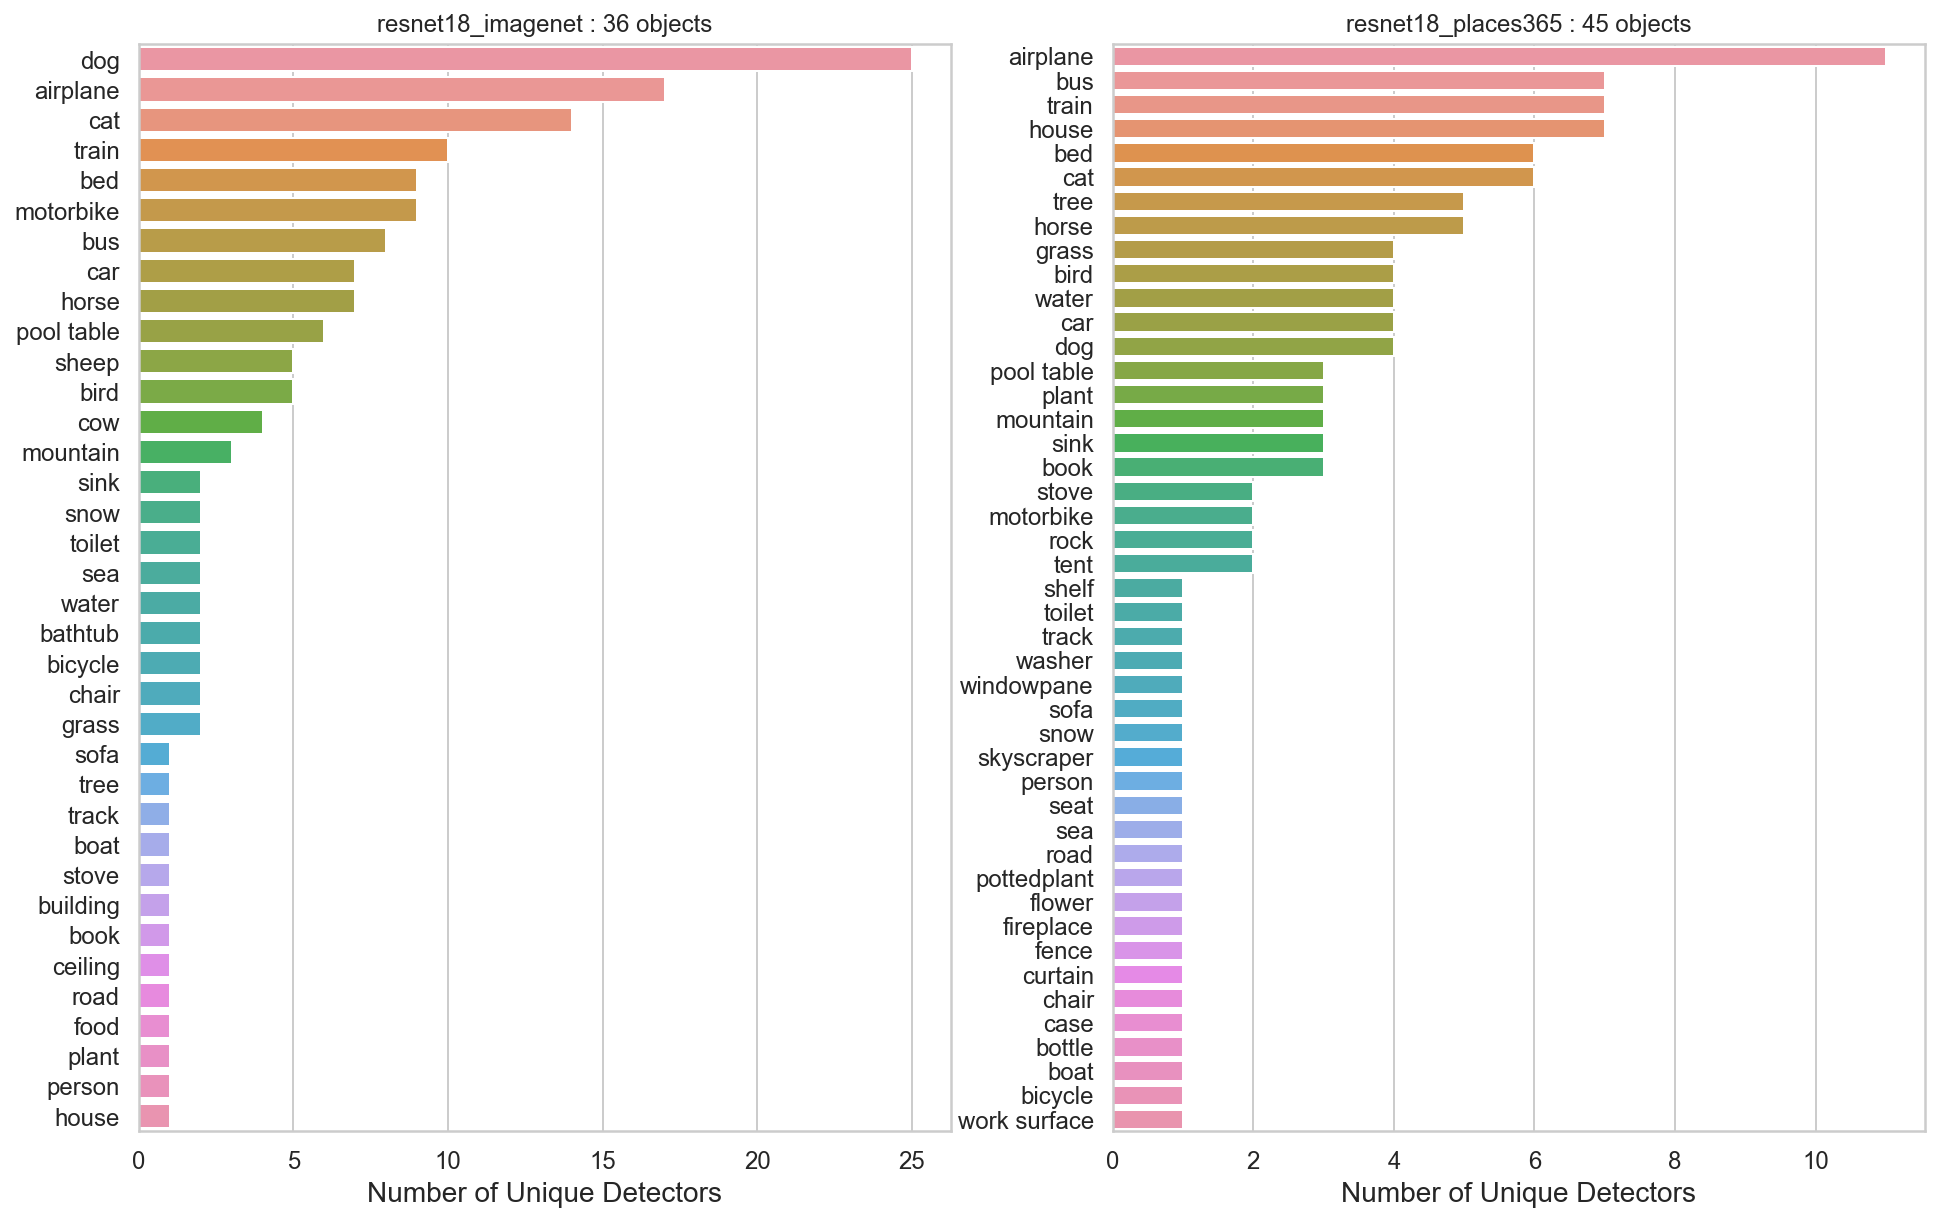

In [9]:
f, ax = plt.subplots(1, 2, figsize=(16, 10))
sns.barplot(x="unit", y="label", data=df_r18_imgnet_object, ax=ax[0])
ax[0].set_title(f"resnet18_imagenet : {len(df_r18_imgnet_object)} objects")
ax[0].set_xlabel("Number of Unique Detectors")
ax[0].set_ylabel("")
sns.barplot(x="unit", y="label", data=df_r18_p365_object, ax=ax[1])
ax[1].set_title(f"resnet18_places365 : {len(df_r18_p365_object)} objects")
ax[1].set_xlabel("Number of Unique Detectors")
ax[1].set_ylabel("");
f.savefig("images/chapter_06_num_ud_object_training_task.png", dpi=300, bbox_inches="tight")
f.savefig("images/chapter_06_num_ud_object_training_task.pdf", format="pdf", dpi=300, bbox_inches="tight")

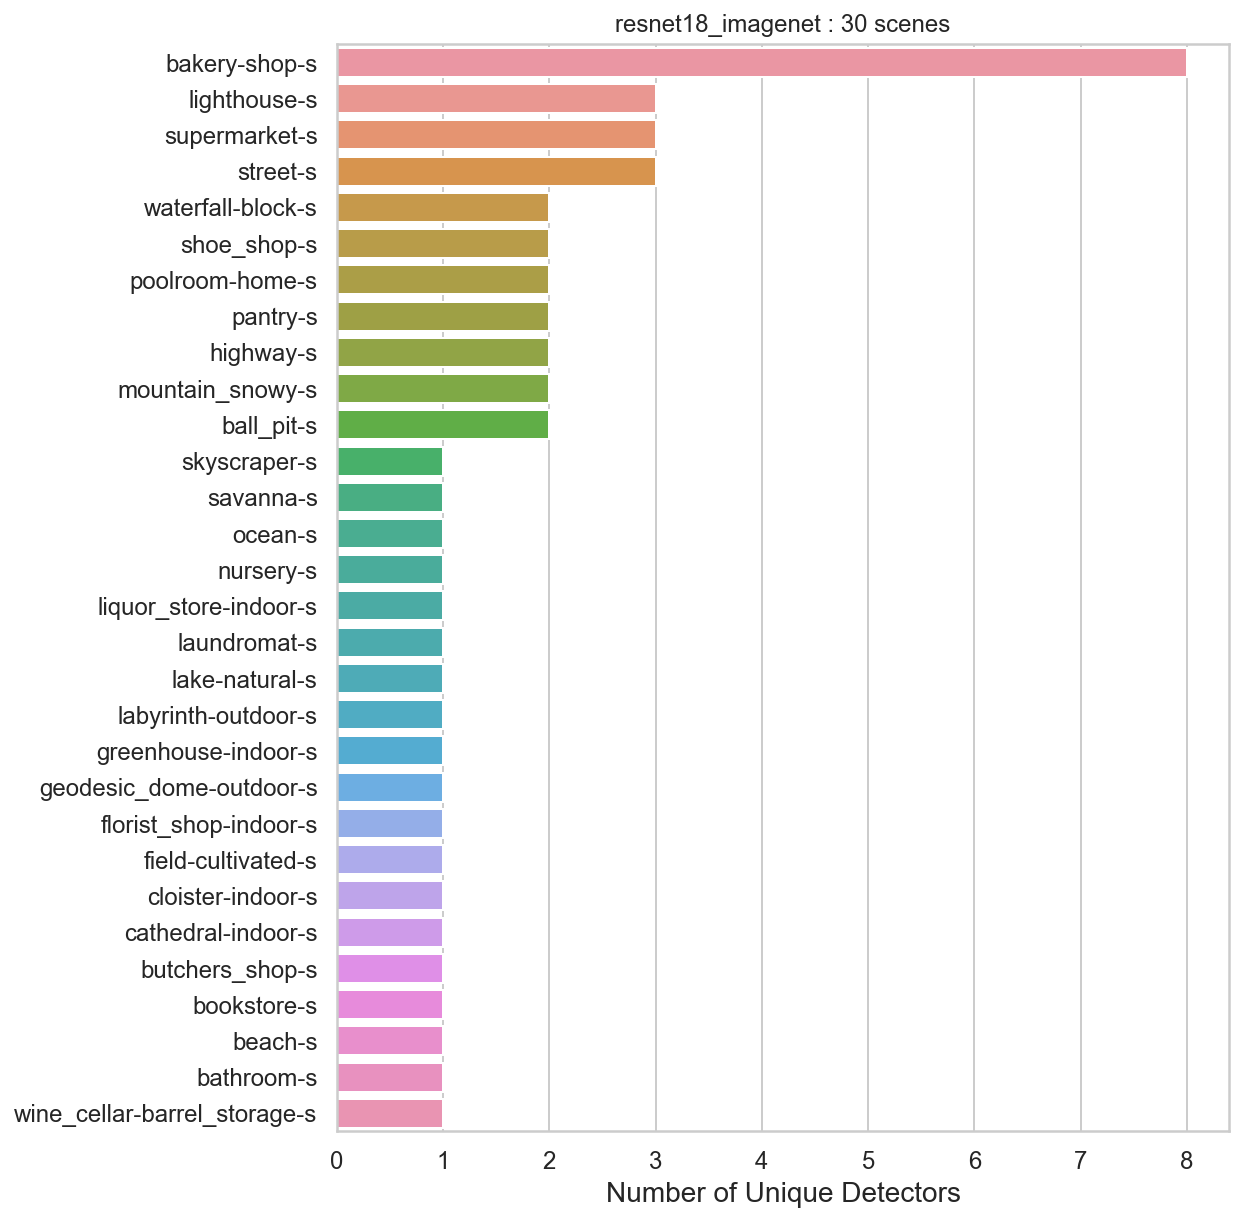

In [10]:
f, ax = plt.subplots(figsize=(8, 10))
sns.barplot(x="unit", y="label", data=df_r18_imgnet_scene, ax=ax)
ax.set_title(f"resnet18_imagenet : {len(df_r18_imgnet_scene)} scenes")
ax.set_xlabel("Number of Unique Detectors")
ax.set_ylabel("");
f.savefig("images/chapter_06_num_ud_scene_training_task_imgnet.png", dpi=300, bbox_inches="tight")
f.savefig("images/chapter_06_num_ud_scene_training_task_imgnet.pdf", format="pdf", dpi=300, bbox_inches="tight")

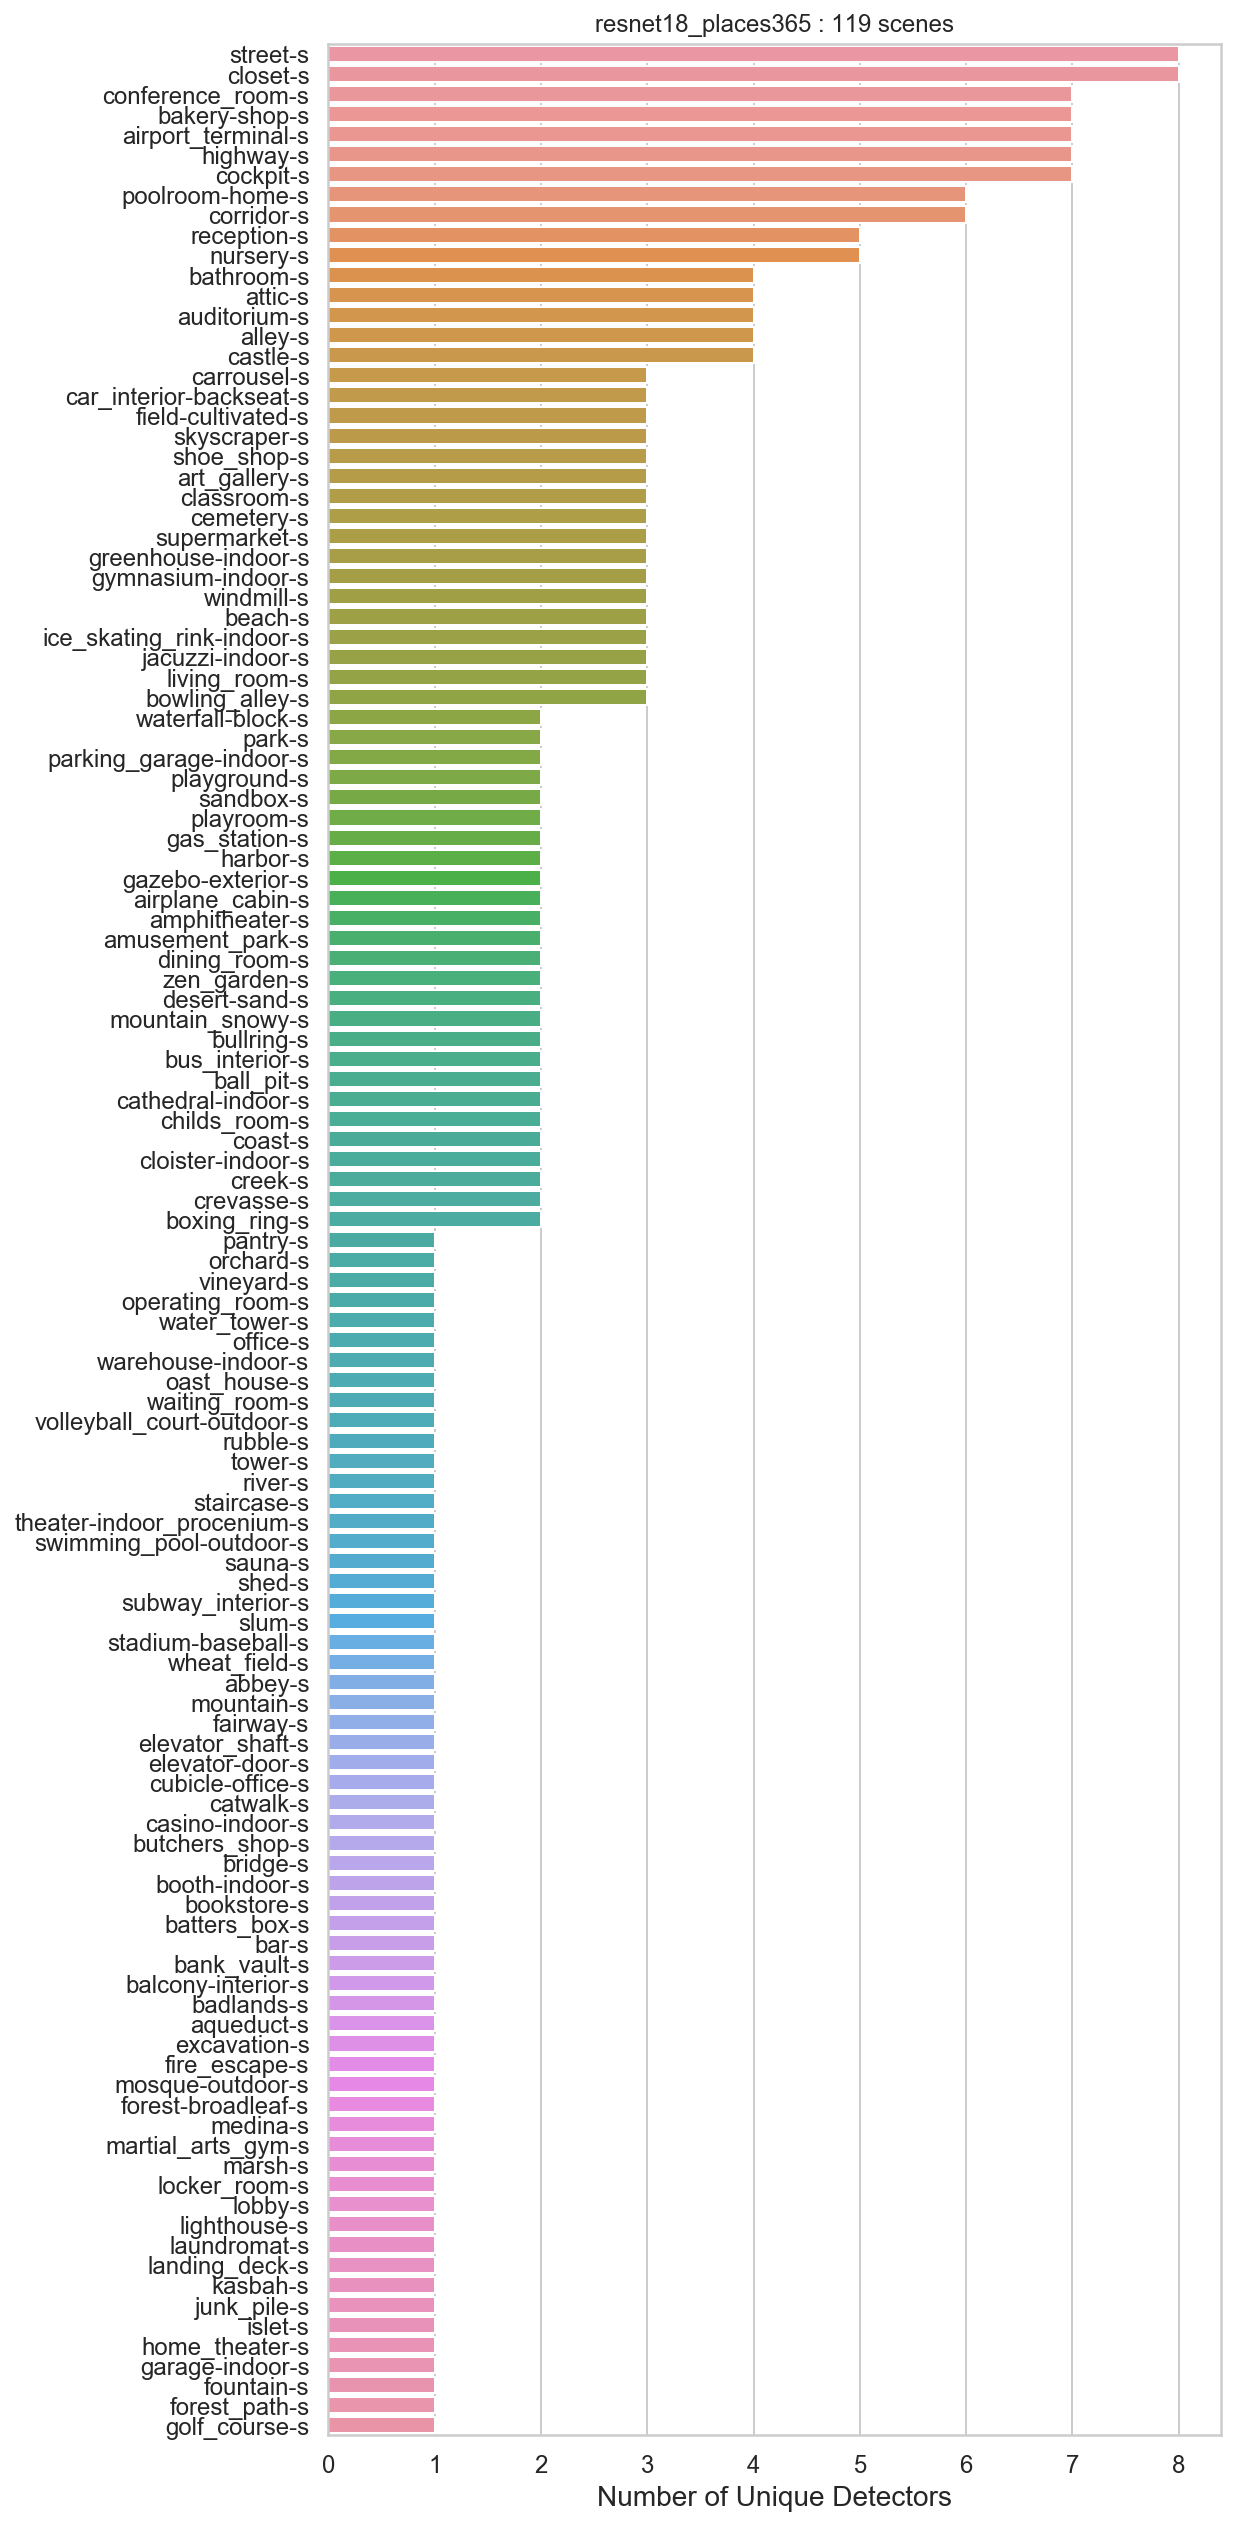

In [11]:
f, ax = plt.subplots(figsize=(8, 22))
sns.barplot(x="unit", y="label", data=df_r18_p365_scene, ax=ax)
ax.set_title(f"resnet18_places365 : {len(df_r18_p365_scene)} scenes")
ax.set_xlabel("Number of Unique Detectors")
ax.set_ylabel("");
f.savefig("images/chapter_06_num_ud_scene_training_task_p365.png", dpi=300, bbox_inches="tight")
f.savefig("images/chapter_06_num_ud_scene_training_task_p365.pdf", format="pdf", dpi=300, bbox_inches="tight")

In [12]:
f, ax = plt.subplots(1, 2, figsize=(16, 10))
sns.barplot(x="unit", y="label", data=df_r18_imgnet_texture, ax=ax[0])
ax[0].set_title(f"resnet18_imagenet : {len(df_r18_imgnet_texture)} textures")
ax[0].set_xlabel("Number of Unique Detectors")
ax[0].set_ylabel("")
sns.barplot(x="unit", y="label", data=df_r18_p365_texture, ax=ax[1])
ax[1].set_title(f"resnet18_places365 : {len(df_r18_p365_texture)} textures")
ax[1].set_xlabel("Number of Unique Detectors")
ax[1].set_ylabel("");
f.savefig("images/chapter_06_num_ud_texture_training_task.png", dpi=300, bbox_inches="tight")
f.savefig("images/chapter_06_num_ud_texture_training_task.pdf", format="pdf", dpi=300, bbox_inches="tight")

# Unique Detectors - Layers

In [13]:
def compute_unique_detectors_layers(**kwargs):
    network_names = kwargs.get("network_names", 
                               ["resnet18"])
    datasets = kwargs.get("datasets", 
                          ["imagenet", "places365"])
    results_dir = kwargs.get("results_dir", "result")
    categories = kwargs.get("categories", 
                            ["object",
                             "scene", 
                             "part",
                             "texture", 
                             "color"])
    iou_thres = kwargs.get("iou_thres",
                           0.04) # to determine if a unit is an interpretable detector
    layers = kwargs.get("layers", ["layer1", "layer2", "layer3", "layer4"])
    
    ud_data = []
    for network_name in network_names:
        for dataset in datasets:
            for layer in layers:
                result_file = os.path.join(results_dir, 
                                           f"pytorch_{network_name}_{dataset}/tally_{layer}.csv")
                try:
                    df_result = pd.read_csv(result_file)
                except FileNotFoundError:
                    continue

                ud = OrderedDict()
                ud["network_name"] = network_name
                ud["dataset"] = dataset
                ud["layer"] = layer
                ud["num_units"] = len(df_result)

                num_ud = 0
                for category in categories:
                    df_cat = df_result[df_result["category"] == category].reset_index(drop=True)
                    df_unique_detectors = df_cat[df_cat[f"{category}-iou"] > iou_thres].reset_index(drop=True)
                    ud[f"num_ud_{category}"] = len(df_unique_detectors)
                    ud[f"num_ud_{category}_pc"] = len(df_unique_detectors) / ud["num_units"] * 100
                    num_ud += len(df_unique_detectors)
                ud["num_ud"] = num_ud
                ud["num_ud_pc"] = ud["num_ud"] / ud["num_units"] * 100
                ud_data.append(ud)
    df_ud_layer = pd.DataFrame(ud_data)
    return df_ud_layer

In [16]:
df_ud_layer = compute_unique_detectors_layers()

In [18]:
df_ud_layer.head()

network_name    dataset   layer  num_units  num_ud_object  num_ud_object_pc  \
0     resnet18   imagenet  layer1         64              0          0.000000   
1     resnet18   imagenet  layer2        128              0          0.000000   
2     resnet18   imagenet  layer3        256              5          1.953125   
3     resnet18   imagenet  layer4        512            160         31.250000   
4     resnet18  places365  layer1         64              0          0.000000   

   num_ud_scene  num_ud_scene_pc  num_ud_part  num_ud_part_pc  num_ud_texture  \
0             0         0.000000            0        0.000000               0   
1             0         0.000000            1        0.781250               8   
2             0         0.000000           18        7.031250              23   
3            50         9.765625           26        5.078125              65   
4             0         0.000000            0        0.000000               2   

   num_ud_texture_pc  num_ud_color  num_ud_color_pc  num_ud  num_ud_pc  
0           0.000000             1         1.562500       1   1.562500  
1           6.250000             0         0.000000       9   7.031250  
2           8.984375             0         0.000000      46  17.968750  
3          12.695312             1         0.195312     302  58.984375  
4           3.125000             3         4.687500       5   7.812500

In [38]:
def plot_ud_layers(df_ud_layer):
    from matplotlib.patches import Ellipse
    def plot_ud_layers_dataset(df_ud_layer_dataset, ax):
        object_uds = df_ud_layer_dataset["num_ud_object_pc"].values
        scene_uds = df_ud_layer_dataset["num_ud_scene_pc"].values
        part_uds = df_ud_layer_dataset["num_ud_part_pc"].values
        texture_uds = df_ud_layer_dataset["num_ud_texture_pc"].values
        color_uds = df_ud_layer_dataset["num_ud_color_pc"].values
        ax.plot(object_uds, '^-', label="object")
        ax.plot(scene_uds, 's-', label="scene")
        ax.plot(part_uds, 'o-', label="part")
        ax.plot(texture_uds, '*-', label="texture")
        ax.plot(color_uds, 'v-', label="color")
        ax.legend()
        ax.set_xticks([0, 1, 2, 3])
        ax.set_xticklabels(["Layer 1", "Layer 2", "Layer 3", "Layer 4"])
        ax.set_ylabel("Proportion of Unique Detectors (%)")
        
        el = Ellipse((-1, 1), 0.5, 0.5)
        ax.add_patch(el)
        ax.annotate('object',
            xy=(3, object_uds[-1]), xycoords='data',
            xytext=(-50, 10), textcoords='offset points',
            size=12,
            # bbox=dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            patchB=el,
                            connectionstyle="angle3,angleA=0,angleB=-90"))
        ax.annotate('scene',
            xy=(3, scene_uds[-1]), xycoords='data',
            xytext=(-50, 10), textcoords='offset points',
            size=12,
            # bbox=dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            patchB=el,
                            connectionstyle="angle3,angleA=0,angleB=-90"))
        ax.annotate('part',
            xy=(3, part_uds[-1]), xycoords='data',
            xytext=(-50, 10), textcoords='offset points',
            size=12,
            # bbox=dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            patchB=el,
                            connectionstyle="angle3,angleA=0,angleB=-90"))
        ax.annotate('texture',
            xy=(3, texture_uds[-1]), xycoords='data',
            xytext=(-50, 10), textcoords='offset points',
            size=12,
            # bbox=dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            patchB=el,
                            connectionstyle="angle3,angleA=0,angleB=-90"))
        ax.annotate('color',
            xy=(3, color_uds[-1]), xycoords='data',
            xytext=(-50, 10), textcoords='offset points',
            size=12,
            # bbox=dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            patchB=el,
                            connectionstyle="angle3,angleA=0,angleB=-90"))
    df_ud_layer_r18_p365 = df_ud_layer[(df_ud_layer["network_name"] == "resnet18") & 
                                   (df_ud_layer["dataset"] == "places365")].reset_index(drop=True)
    df_ud_layer_r18_imgnet = df_ud_layer[(df_ud_layer["network_name"] == "resnet18") & 
                                   (df_ud_layer["dataset"] == "imagenet")].reset_index(drop=True)
    
    f, ax = plt.subplots(2, 1, figsize=(8, 10))
    plot_ud_layers_dataset(df_ud_layer_r18_imgnet, ax[0])
    ax[0].set_title("resnet18_imagenet")
    plot_ud_layers_dataset(df_ud_layer_r18_p365, ax[1])
    ax[1].set_title("resnet18_places365")
    
    return f, ax

In [39]:
f, ax = plot_ud_layers(df_ud_layer)
f.savefig("images/chapter_06_num_ud_layers.png", dpi=300, bbox_inches="tight")
f.savefig("images/chapter_06_num_ud_layers.pdf", format="pdf", dpi=300, bbox_inches="tight")

# Unit Concept Detectors

In [13]:
def get_image_and_stats(**kwargs):
    network_name = kwargs.get("network_name", 
                              "resnet18")
    dataset = kwargs.get("dataset", 
                          "places365")
    results_dir = kwargs.get("results_dir", "result")
    layer = kwargs.get("layer", "layer4")
    unit = kwargs.get("unit", "0000")
    
    result_file = os.path.join(results_dir, 
                              f"pytorch_{network_name}_{dataset}/tally_{layer}.csv")
    try:
        df_result = pd.read_csv(result_file)
    except FileNotFoundError:
        return None, None
    
    image_dir = os.path.join(results_dir,
                             f"pytorch_{network_name}_{dataset}/html/image")
    image_file = os.path.join(image_dir,
                              f"{layer}-{unit}.jpg")
    
    img = mpimg.imread(image_file)
    
    df_unit_stats = df_result[df_result["unit"] == int(unit)+1]
    stats = None
    if len(df_unit_stats) > 0:
        stats = {
            "category": df_unit_stats["category"].tolist()[0],
            "label": df_unit_stats["label"].tolist()[0],
            "iou": df_unit_stats["score"].tolist()[0]
        }
    return img, stats

In [48]:
img_247, stats_247 = get_image_and_stats(unit="0246")
img_39, stats_39 = get_image_and_stats(unit="0038")
f, ax = plt.subplots(2, 1, figsize=(15, 4))
ax[0].imshow(img_247, interpolation='nearest')
ax[0].grid(False)
ax[0].axis(False)
ax[0].set_title(f"Unit: 247, Label: {stats_247['label']}, Category: {stats_247['category']}, IoU: {stats_247['iou']:.2f}", 
                fontsize=16)
ax[1].imshow(img_39, interpolation='nearest')
ax[1].grid(False)
ax[1].axis(False)
ax[1].set_title(f"Unit: 39, Label: {stats_39['label']}, Category: {stats_39['category']}, IoU: {stats_39['iou']:.2f}", 
                fontsize=16);
f.savefig("images/chapter_06_airplane_unit_concept_detectors.png", dpi=300, bbox_inches="tight")
f.savefig("images/chapter_06_airplane_unit_concept_detectors.pdf", format="pdf", dpi=300, bbox_inches="tight")

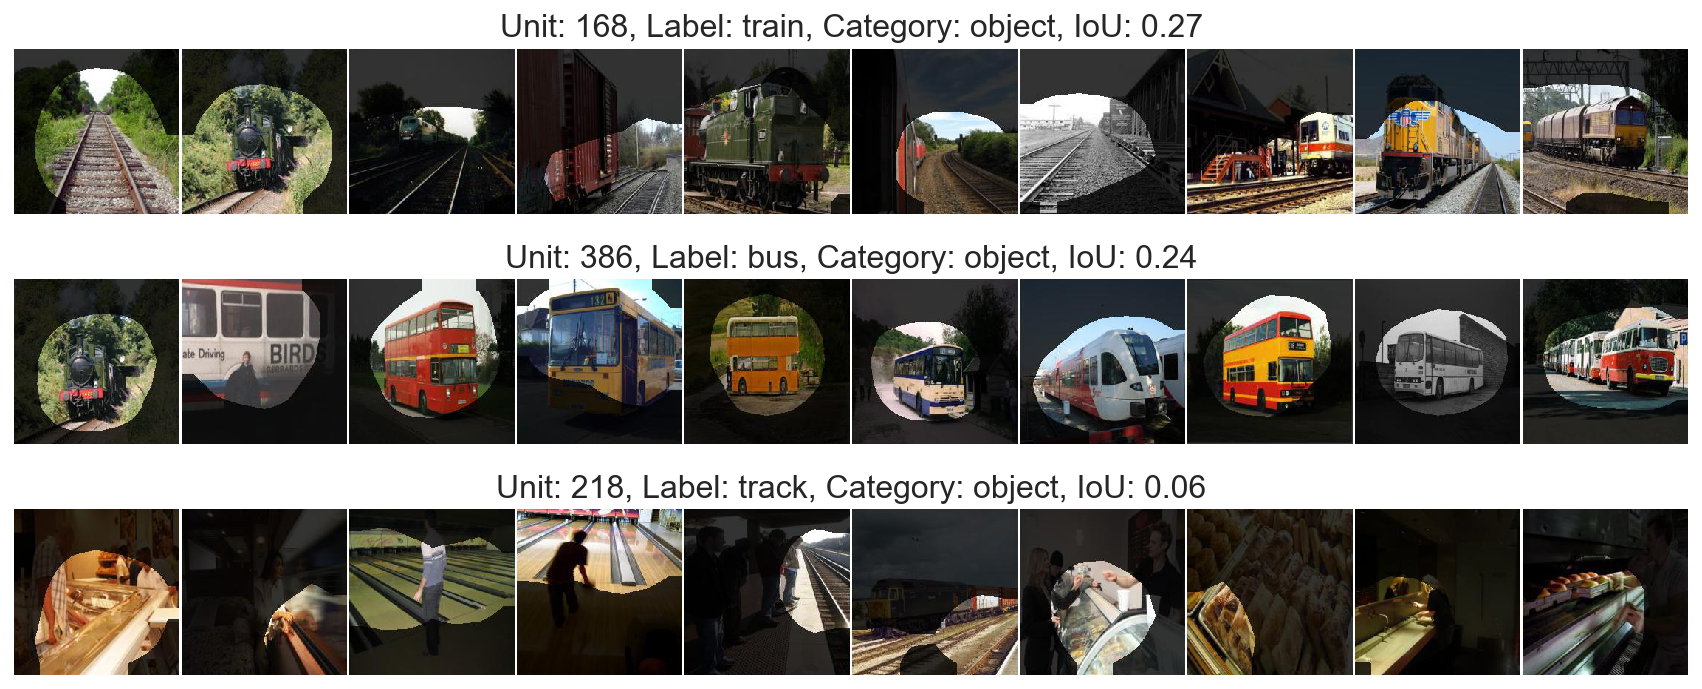

In [49]:
img_168, stats_168 = get_image_and_stats(unit="0167")
img_386, stats_386 = get_image_and_stats(unit="0385")
img_218, stats_218 = get_image_and_stats(unit="0217")
f, ax = plt.subplots(3, 1, figsize=(15, 6))
ax[0].imshow(img_168, interpolation='nearest')
ax[0].grid(False)
ax[0].axis(False)
ax[0].set_title(f"Unit: 168, Label: {stats_168['label']}, Category: {stats_168['category']}, IoU: {stats_168['iou']:.2f}", 
                fontsize=16)
ax[1].imshow(img_386, interpolation='nearest')
ax[1].grid(False)
ax[1].axis(False)
ax[1].set_title(f"Unit: 386, Label: {stats_386['label']}, Category: {stats_386['category']}, IoU: {stats_386['iou']:.2f}", 
                fontsize=16);
ax[2].imshow(img_218, interpolation='nearest')
ax[2].grid(False)
ax[2].axis(False)
ax[2].set_title(f"Unit: 218, Label: {stats_218['label']}, Category: {stats_218['category']}, IoU: {stats_218['iou']:.2f}", 
                fontsize=16);
f.savefig("images/chapter_06_train_bus_track_unit_concept_detectors.png", dpi=300, bbox_inches="tight")
f.savefig("images/chapter_06_train_bus_track_unit_concept_detectors.pdf", format="pdf", dpi=300, bbox_inches="tight")

In [50]:
img_454, stats_454 = get_image_and_stats(unit="0453")
img_292, stats_292 = get_image_and_stats(unit="0291")
f, ax = plt.subplots(2, 1, figsize=(15, 4))
ax[0].imshow(img_454, interpolation='nearest')
ax[0].grid(False)
ax[0].axis(False)
ax[0].set_title(f"Unit: 454, Label: {stats_454['label']}, Category: {stats_454['category']}, IoU: {stats_454['iou']:.2f}", 
                fontsize=16)
ax[1].imshow(img_292, interpolation='nearest')
ax[1].grid(False)
ax[1].axis(False)
ax[1].set_title(f"Unit: 292, Label: {stats_292['label']}, Category: {stats_292['category']}, IoU: {stats_292['iou']:.2f}", 
                fontsize=16);
f.savefig("images/chapter_06_car_dog_unit_concept_detectors.png", dpi=300, bbox_inches="tight")
f.savefig("images/chapter_06_car_dog_unit_concept_detectors.pdf", format="pdf", dpi=300, bbox_inches="tight")

In [51]:
img_379, stats_379 = get_image_and_stats(unit="0378")
img_370, stats_370 = get_image_and_stats(unit="0369")
f, ax = plt.subplots(2, 1, figsize=(15, 4))
ax[0].imshow(img_379, interpolation='nearest')
ax[0].grid(False)
ax[0].axis(False)
ax[0].set_title(f"Unit: 379, Label: {stats_379['label']}, Category: {stats_379['category']}, IoU: {stats_379['iou']:.2f}", 
                fontsize=16)
ax[1].imshow(img_370, interpolation='nearest')
ax[1].grid(False)
ax[1].axis(False)
ax[1].set_title(f"Unit: 370, Label: {stats_370['label']}, Category: {stats_370['category']}, IoU: {stats_370['iou']:.2f}", 
                fontsize=16);
f.savefig("images/chapter_06_highway_unit_concept_detectors.png", dpi=300, bbox_inches="tight")
f.savefig("images/chapter_06_nursery_unit_concept_detectors.pdf", format="pdf", dpi=300, bbox_inches="tight")